In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import math

from trainer import Trainer
from model import LSTM

In [2]:
torch.manual_seed(2)

<IPython.core.display.Javascript object>


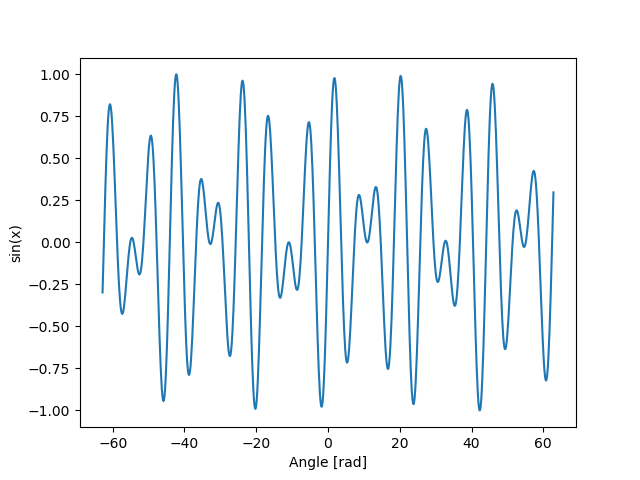

In [39]:
%matplotlib notebook
x = np.linspace(-20*np.pi, 20*np.pi, 800)
# out = np.sin(x)+np.sin(0.71*x)+np.sin(0.12*x)+np.sin(0.32*x)+np.sin(0.66*x)+np.sin(0.48*x)
# out = np.sin(x)+np.sin(0.71*x)+np.sin(0.12*x)+np.sin(0.32*x)+np.sin(0.66*x)
out = np.sin(x)+np.sin(0.71*x)
scaler = MinMaxScaler((-1,1))
out = np.squeeze(scaler.fit_transform(out.reshape(-1,1)))
plt.plot(x, out)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [40]:
input_seq_len = 20
output_seq_len = 1
shift_per_batch = 1
epochs = 120
batch_size = 6

batch_num = (len(out)-input_seq_len+shift_per_batch)/shift_per_batch - output_seq_len

x_in = np.array([out[i*shift_per_batch:i*shift_per_batch+input_seq_len] 
           for i in range(int(batch_num))])

y_in = np.array([out[i*shift_per_batch+input_seq_len:i*shift_per_batch+input_seq_len+output_seq_len] 
           for i in range(int(batch_num))])

x_train = torch.from_numpy(x_in[:round(x_in.shape[0]*0.7),:]).t().unsqueeze(-1).float()
x_test = torch.from_numpy(x_in[round(x_in.shape[0]*0.7):,:]).t().unsqueeze(-1).float()
y_train = torch.from_numpy(y_in[:round(y_in.shape[0]*0.7),:]).t().float()
y_test = torch.from_numpy(y_in[round(y_in.shape[0]*0.7):,:]).t().float()

x_full = torch.from_numpy(x_in).t().unsqueeze(-1).float()
y_full = torch.from_numpy(y_in).t().float()

In [41]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_full.shape, y_full.shape

(torch.Size([20, 546, 1]),
 torch.Size([20, 234, 1]),
 torch.Size([1, 546]),
 torch.Size([1, 234]),
 torch.Size([20, 780, 1]),
 torch.Size([1, 780]))

In [42]:
trainer = Trainer(input_size = 1,
                  hidden_size = 32,
                  batch_size = batch_size,
                  output_dim = (256,64,output_seq_len),
                  num_layers = 5,
                  learning_rate = 0.01,
                  seq_len = input_seq_len)

In [43]:
for t in range(epochs):
    loss_train = trainer.learn(x_train,y_train)
    loss_test, _ = trainer.evaluate(x_test,y_test)
    print('epoch = {} - train loss ---> {:05f} - val loss ---> {:05f}'.format(t,loss_train,loss_test))

epoch = 0 - train loss ---> 0.256913 - val loss ---> 4.977492
epoch = 1 - train loss ---> 4.950504 - val loss ---> 7.823276
epoch = 2 - train loss ---> 7.936932 - val loss ---> 0.602847
epoch = 3 - train loss ---> 0.658212 - val loss ---> 0.440842
epoch = 4 - train loss ---> 0.466157 - val loss ---> 0.362025
epoch = 5 - train loss ---> 0.388490 - val loss ---> 0.281454
epoch = 6 - train loss ---> 0.323393 - val loss ---> 0.671360
epoch = 7 - train loss ---> 0.721940 - val loss ---> 0.573468
epoch = 8 - train loss ---> 0.623233 - val loss ---> 0.336646
epoch = 9 - train loss ---> 0.381726 - val loss ---> 0.230028
epoch = 10 - train loss ---> 0.270029 - val loss ---> 0.218551
epoch = 11 - train loss ---> 0.254447 - val loss ---> 0.231376
epoch = 12 - train loss ---> 0.263894 - val loss ---> 0.236098
epoch = 13 - train loss ---> 0.268374 - val loss ---> 0.230433
epoch = 14 - train loss ---> 0.263209 - val loss ---> 0.221916
epoch = 15 - train loss ---> 0.255954 - val loss ---> 0.217314
ep

In [8]:
def get_prediction_batch(x,y,shift,input_size,output_size, lookahead):
    predictions = []
    for i in range(round((lookahead-output_size+shift)/shift)):
        out_pred = trainer.predict(x)
        x_shifted = torch.roll(x, -shift)
        x_shifted[:,-shift:,:] = x[:,-shift:,:]
        for i in range(shift,0,-1):
            new_col = torch.roll(x[:,-i,:], -shift)
            if i == shift:
                new_col[-shift:] = out_pred[:shift,-1].unsqueeze(1)
                x_shifted[:,-i,:] = new_col
            else:
                new_col[-shift:] = torch.cat((x_shifted[-1:,-i+1],out_pred[:shift-1,-i+1].unsqueeze(1)))
                x_shifted[:,-i,:] = new_col
        x = x_shifted
        predictions.append(out_pred[:,-1])
    return x, predictions

In [9]:
x_full.shape

torch.Size([20, 480, 1])

In [53]:
def get_prediction(x, shift ,output_size, lookahead):
    outputs = []
    init_hidden = 479
    for i in range(round(lookahead/output_size) + init_hidden):
        if i == 0:
            trainer.model.hidden = (torch.zeros(trainer.model.num_layers,
                                                1,
                                                trainer.model.hidden_dim),
                                    torch.zeros(trainer.model.num_layers,
                                                1,
                                                trainer.model.hidden_dim))
        if i < init_hidden + 1:
            input_model = x[:,i-(init_hidden+1)]
            output = trainer.predict(input_model.unsqueeze(2))
        else:
            input_model = torch.roll(input_model,-output_size)
            input_model[-output.shape[0]:] = output
            output = trainer.predict(input_model.unsqueeze(2))
        outputs += [output]
        
    return torch.cat(outputs[init_hidden:]).numpy()

In [54]:
lookahead = 101
predictions = get_prediction(x_full,shift_per_batch,output_seq_len,lookahead)
predictions.shape

(101, 1)

In [55]:
def extend(x, lookahead):
    diff_x = x[-1]-x[-2]
    x_new = x[-1] + diff_x
    extended = []

    for i in range(lookahead-1):
        extended.append(x_new)
        x_new += diff_x

    extended = np.array(extended)
    
    return np.append(x, extended)

<IPython.core.display.Javascript object>


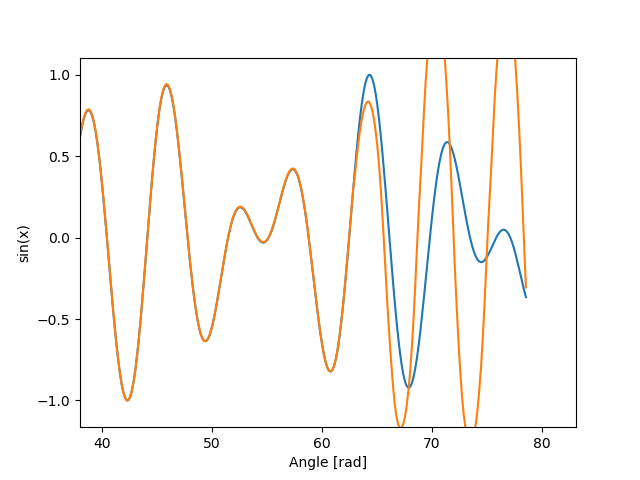

In [56]:
%matplotlib notebook
x = np.linspace(-20*np.pi, 20*np.pi, 800)
x_new = extend(x,lookahead)
# out_new = np.sin(x_new)+np.sin(0.71*x_new)+np.sin(0.12*x_new)+np.sin(0.32*x_new)+np.sin(0.66*x_new)+np.sin(0.48*x_new)
# out_new = np.sin(x_new)+np.sin(0.71*x_new)+np.sin(0.12*x_new)+np.sin(0.32*x_new)+np.sin(0.66*x_new)
out_new = np.sin(x_new)+np.sin(0.71*x_new)
out_pred = np.append(out, predictions[1:])
scaler = MinMaxScaler((-1,1))
out_new = np.squeeze(scaler.fit_transform(out_new.reshape(-1,1)))
# scaler1 = MinMaxScaler((-1,1))
# out_pred = np.squeeze(scaler1.fit_transform(out_pred.reshape(-1,1)))
plt.plot(x_new, out_new)
plt.plot(x_new, out_pred)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()